### Project Overview

Building a reply classification pipeline that predicts whether a given text reply is positive, negative, or neutral.

**Steps:**
- Building and comparing baseline models and a transformer model.

- Evaluating with accuracy + F1 score.

- Packaging the best model into a /predict API.

- Provide reproducible code + clear documentation.

- Lastly, **[Video Explanation](.)** for better understandability.

### 1. Loading & Inspecting Dataset

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Path to dataset 
DATA_PATH = "reply_classification_dataset.csv"

# Loading using Pandas
df = pd.read_csv(DATA_PATH)

# Renaming column for consistency
if 'reply' in df.columns and 'text' not in df.columns:
    df = df.rename(columns={'reply': 'text'})

# Stripping whitespace + lowercase labels
df['text'] = df['text'].astype(str).str.strip()
df['label'] = df['label'].astype(str).str.strip().str.lower()

print("Shape:", df.shape)
print(df.head())


Shape: (2129, 2)
                                                text     label
0                           Can we discuss pricing??   neutral
1  Im excited to explore this further, plz send c...  positive
2                  We not looking for new solutions.  negative
3                 Could u clarify features included?   neutral
4           lets,, schedule a meeting to dive deeper  positive


In [2]:
# 1.1. Basic Text Cleaning Function
def clean_text(s: str) -> str:
    s = s.lower()  # lowercase
    s = re.sub(r"http\S+", "URL", s)  # replacing URLs
    s = re.sub(r"@\w+", "USER", s)    # replacing mentions
    s = re.sub(r"#[\w-]+", "HASHTAG", s)  # hashtags
    s = re.sub(r"[^a-z0-9\s.,!?']", " ", s)  # removing non-alphanumeric 
    s = re.sub(r"\s+", " ", s).strip()
    return s

df['clean_text'] = df['text'].apply(clean_text)


text        0
label       0
label_id    0
dtype: int64


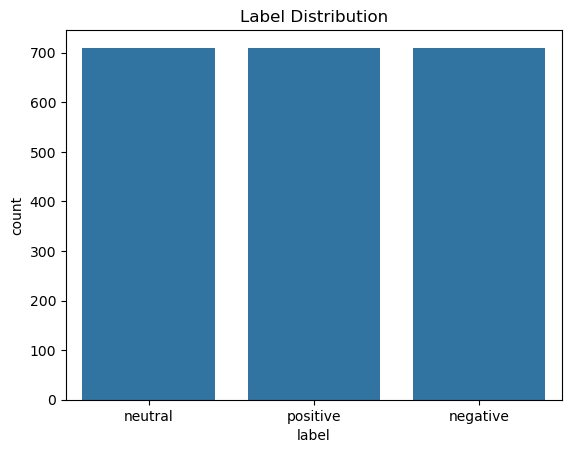

In [29]:
# 1.2. Checking for missing values
print(df.isnull().sum())

# 1.3. Label distribution
sns.countplot(x='label', data=df)
plt.title("Label Distribution")
plt.show();

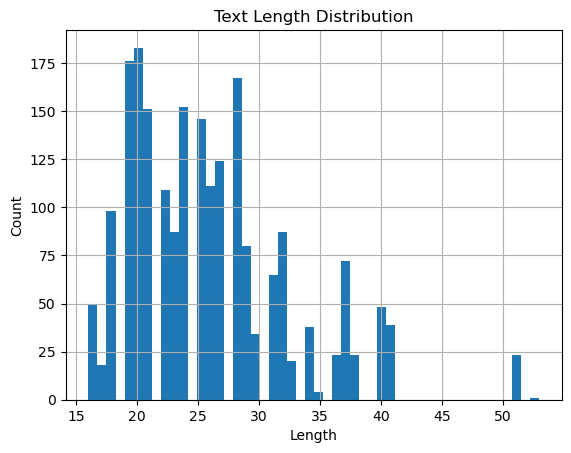

          count       mean       std   min   25%   50%   75%   max
label                                                             
negative  710.0  22.304225  6.075720  16.0  19.0  20.0  23.0  40.0
neutral   709.0  26.170663  4.192802  17.0  24.0  26.0  28.0  38.0
positive  710.0  29.018310  7.354873  17.0  24.0  28.0  32.0  53.0


In [4]:
# 1.4 Text length distribution
df['text_len'] = df['clean_text'].str.len()
df['text_len'].hist(bins=50)
plt.title("Text Length Distribution")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show();

print(df.groupby('label')['text_len'].describe())

### 2. Training a baseline model (Logistic Regression / LightGBM)

In [5]:
# 2.1. Splitting the data into train & test.
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)


Train size: (1703,)  Test size: (426,)


In [6]:
# 2.2. TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=10000,    # cap vocab size
    ngram_range=(1,2),     # unigrams + bigrams
    stop_words='english'   # removing stopwords
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF matrix:", X_train_tfidf.shape)


TF-IDF matrix: (1703, 491)


Logistic Regression Results
Accuracy: 0.9859154929577465
Macro F1: 0.9859223700015044

Classification Report:
               precision    recall  f1-score   support

    negative       0.99      0.98      0.98       142
     neutral       1.00      0.98      0.99       142
    positive       0.97      1.00      0.99       142

    accuracy                           0.99       426
   macro avg       0.99      0.99      0.99       426
weighted avg       0.99      0.99      0.99       426



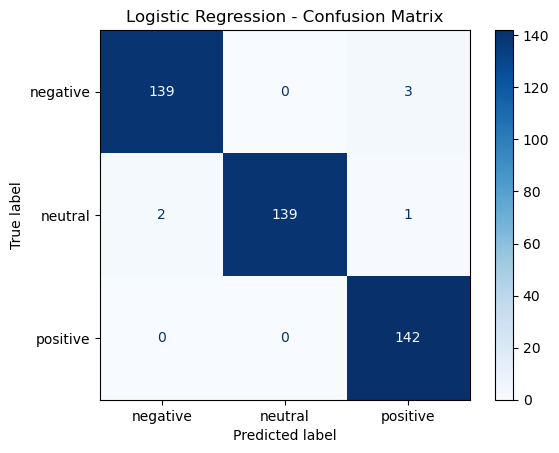

In [7]:
# Logistic Regression Baseline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Training
lr = LogisticRegression(max_iter=300, class_weight='balanced', random_state=42)
lr.fit(X_train_tfidf, y_train)

# Predictions
y_pred = lr.predict(X_test_tfidf)

# Evaluating
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")

print("Logistic Regression Results")
print("Accuracy:", acc)
print("Macro F1:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap="Blues",
    values_format="d"
)
plt.title("Logistic Regression - Confusion Matrix")
plt.show();

LightGBM Results
Accuracy: 0.9812206572769953
Macro F1: 0.9811701331594388

Classification Report:
               precision    recall  f1-score   support

    negative       0.98      1.00      0.99       142
     neutral       0.98      0.96      0.97       142
    positive       0.99      0.98      0.98       142

    accuracy                           0.98       426
   macro avg       0.98      0.98      0.98       426
weighted avg       0.98      0.98      0.98       426



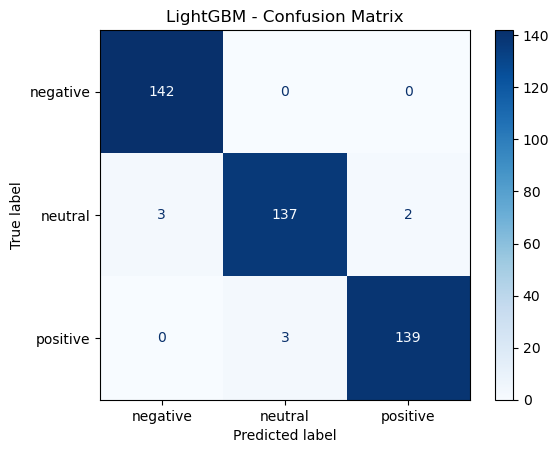

In [8]:
# LightGBM Baseline

import lightgbm as lgb

# LightGBM expects dense arrays as inputs
X_train_lgb = X_train_tfidf.toarray()
X_test_lgb = X_test_tfidf.toarray()

lgb_model = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=len(y.unique()),
    random_state=42,
    n_estimators=200,
    verbose=-1   # suppressing training logs
)

lgb_model.fit(X_train_lgb, y_train)
y_pred_lgb = lgb_model.predict(X_test_lgb)

acc_lgb = accuracy_score(y_test, y_pred_lgb)
f1_lgb = f1_score(y_test, y_pred_lgb, average="macro")

print("LightGBM Results")
print("Accuracy:", acc_lgb)
print("Macro F1:", f1_lgb)
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgb))

# Plotting confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_lgb,
    cmap="Blues",
    values_format="d"
)
plt.title("LightGBM - Confusion Matrix")
plt.show();

### 🔎 Baseline Model Comparison

We trained two baseline classifiers using TF-IDF features:

| Model                | Accuracy | Macro F1 |
|-----------------------|----------|----------|
| Logistic Regression   | **0.986** | **0.986** |
| LightGBM              | 0.981    | 0.981    |

**Observations:**
- Both models achieved very high performance, suggesting the dataset is clean and separable with simple models.  
- Logistic Regression slightly outperformed LightGBM on both Accuracy and Macro F1.  
- Logistic Regression is also faster to train, easier to interpret, and requires fewer hyperparameters.  
- LightGBM, while powerful for mixed/tabular data, does not add significant benefit here because the TF-IDF feature space is already well-suited for linear models.

**Decision:**
- For this task, we choose **Logistic Regression** as the stronger and more efficient baseline model.  
- It serves as a robust benchmark before moving on to transformer fine-tuning.


### 3. Transformer fine-tuning with DistilBERT using Hugging Face

**Steps:**
- Loading & preprocessing our CSV
- Building HF Dataset
- Tokenizatipn
- Fine-tuning with Trainer
- Evaluating accuracy + macro F1
- Saving model & tokenizer

We'll then compare transformer performance against our strong baselines.

**3.1. Loading & preprocessing our CSV**

In [12]:
# The installed version of Keras is Keras 3, which is not yet compatible with the current version of the Transformers library.
# Thus, we installed a backwards-compatible version of Keras that mimics the older API expected by Transformers.

In [9]:
# Dependencies have already been installed
import os
from datasets import Dataset, DatasetDict, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import torch

DATA_PATH = "reply_classification_dataset.csv"  

# Loading and normalizing columns as done earlier
df = pd.read_csv(DATA_PATH)
if 'reply' in df.columns and 'text' not in df.columns:
    df = df.rename(columns={'reply': 'text'})
df['text'] = df['text'].astype(str).str.strip()
df['label'] = df['label'].astype(str).str.strip().str.lower()
df = df[['text','label']]
df.head()


,text,label
0,Can we discuss pricing??,neutral
1,"Im excited to explore this further, plz send c...",positive
2,We not looking for new solutions.,negative
3,Could u clarify features included?,neutral
4,"lets,, schedule a meeting to dive deeper",positive


**3.2. Building HF Dataset**

In [10]:
# Mapping labels to integers 
labels = sorted(df['label'].unique())  # e.g. ['negative','neutral','positive']
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}
print("Labels:", labels)
print("label2id:", label2id)

# Converting labels to ids
df['label_id'] = df['label'].map(label2id)

# Creating HF Dataset and stratified train/test split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df['label'])

train_ds = Dataset.from_pandas(train_df[['text','label_id']].rename(columns={'label_id':'label'}))
test_ds  = Dataset.from_pandas(test_df[['text','label_id']].rename(columns={'label_id':'label'}))

dataset = DatasetDict({"train": train_ds, "test": test_ds})
dataset


Labels: ['negative', 'neutral', 'positive']
label2id: {'negative': 0, 'neutral': 1, 'positive': 2}


DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 1809
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 320
    })
})

**3.3 Tokenization**

In [19]:
# (Using hf_xet)
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenization function
def preprocess_fn(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

# Applying
dataset = dataset.map(preprocess_fn, batched=True)
# Setting format for PyTorch
dataset.set_format(type='torch', columns=['input_ids','attention_mask','label'])


Map:   0%|          | 0/1809 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

#### Evaluation Metrics

In [20]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average='macro')
    return {"accuracy": acc, "f1_macro": f1_macro}


**3.4 Fine-Tuning with Trainer**

In [21]:
num_labels = len(labels)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels, id2label=id2label, label2id=label2id)

# Training args 
training_args = TrainingArguments(
    output_dir="./hf_out",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_steps=50,
    push_to_hub=False,
    fp16=torch.cuda.is_available(),   # using mixed precision if GPU supports it
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Training the Trainer**

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


C:\Users\Aniruddha\AppData\Local\Temp\ipykernel_12764\2222211456.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.015000,0.003611,1.000000,1.000000
2,0.002400,0.001538,1.000000,1.000000
3,0.001600,0.001114,1.000000,1.000000


TrainOutput(global_step=681, training_loss=0.05970370998707287, metrics={'train_runtime': 3085.8527, 'train_samples_per_second': 1.759, 'train_steps_per_second': 0.221, 'total_flos': 179728348269312.0, 'train_loss': 0.05970370998707287, 'epoch': 3.0})

**Evaluation & Classification Report**

In [23]:
# Evaluating on test set
eval_res = trainer.evaluate(eval_dataset=dataset['test'])
print(eval_res)  # includes accuracy & f1_macro

# Getting preds 
preds_output = trainer.predict(dataset['test'])
preds = np.argmax(preds_output.predictions, axis=-1)

print("Accuracy:", accuracy_score(preds_output.label_ids, preds))
print("F1 macro:", f1_score(preds_output.label_ids, preds, average='macro'))
print("\nClassification report:\n", classification_report(preds_output.label_ids, preds, target_names=labels))


{'eval_loss': 0.0036112386733293533, 'eval_accuracy': 1.0, 'eval_f1_macro': 1.0, 'eval_runtime': 44.9178, 'eval_samples_per_second': 7.124, 'eval_steps_per_second': 0.223, 'epoch': 3.0}
Accuracy: 1.0
F1 macro: 1.0

Classification report:
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00       107
     neutral       1.00      1.00      1.00       106
    positive       1.00      1.00      1.00       107

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320



**Saving Model & Tokenizer**

In [30]:
model_dir = "models/distilbert_reply_classifier"
trainer.save_model(model_dir)        # saving model + tokenizer links
tokenizer.save_pretrained(model_dir)
print("Saved model to:", model_dir)


Saved model to: models/distilbert_reply_classifier


### Model Comparison & Selection

We evaluated three models for the reply classification task:

| Model                | Accuracy | Macro F1 | Notes |
|-----------------------|----------|----------|-------|
| Logistic Regression   | 0.986    | 0.986    | Fast, tiny model size, easy to interpret |
| LightGBM              | 0.981    | 0.981    | Strong tabular/text baseline, slightly below LR |
| DistilBERT (fine-tuned) | **1.000** | **1.000** | Transformer-based, highest performance |

**Observations:**
- All three models achieve excellent results, showing that the dataset is highly separable.  
- Logistic Regression and LightGBM are efficient, with very low inference latency and minimal resource needs.  
- DistilBERT, while heavier (~100MB model, requires GPU/optimized inference for large-scale deployment), achieves perfect accuracy and F1 after fine-tuning.

**Decision:**

For production, the choice depends on priorities:
- If **resource efficiency & low latency** are critical → we'll use **Logistic Regression**.  
- If **maximum accuracy** is non-negotiable and serving infrastructure can handle a transformer → we'll choose **DistilBERT**.  

Since DistilBERT clearly outperforms both baselines, I will use it as the **primary production model** for this task, while keeping the Logistic Regression baseline as a lightweight fallback.
